In [ ]:
import os
import cv2
import math
import random
import numpy as np
import datetime as dt
from collections import deque
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader ,random_split,Dataset
import pandas as pd
from PIL import Image
import shutil

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Appareil utilisé :", device)

Appareil utilisé : cuda


In [4]:
DATA_PATH = "/kaggle/input/human-activities-dataset/Human Activity Recognition - Video Dataset"
All_Classes = os.listdir(DATA_PATH)
All_Classes

['Sitting',
 'Walking While Reading Book',
 'Walking',
 'Standing Still',
 'Clapping',
 'Walking While Using Phone',
 'Meet and Split']

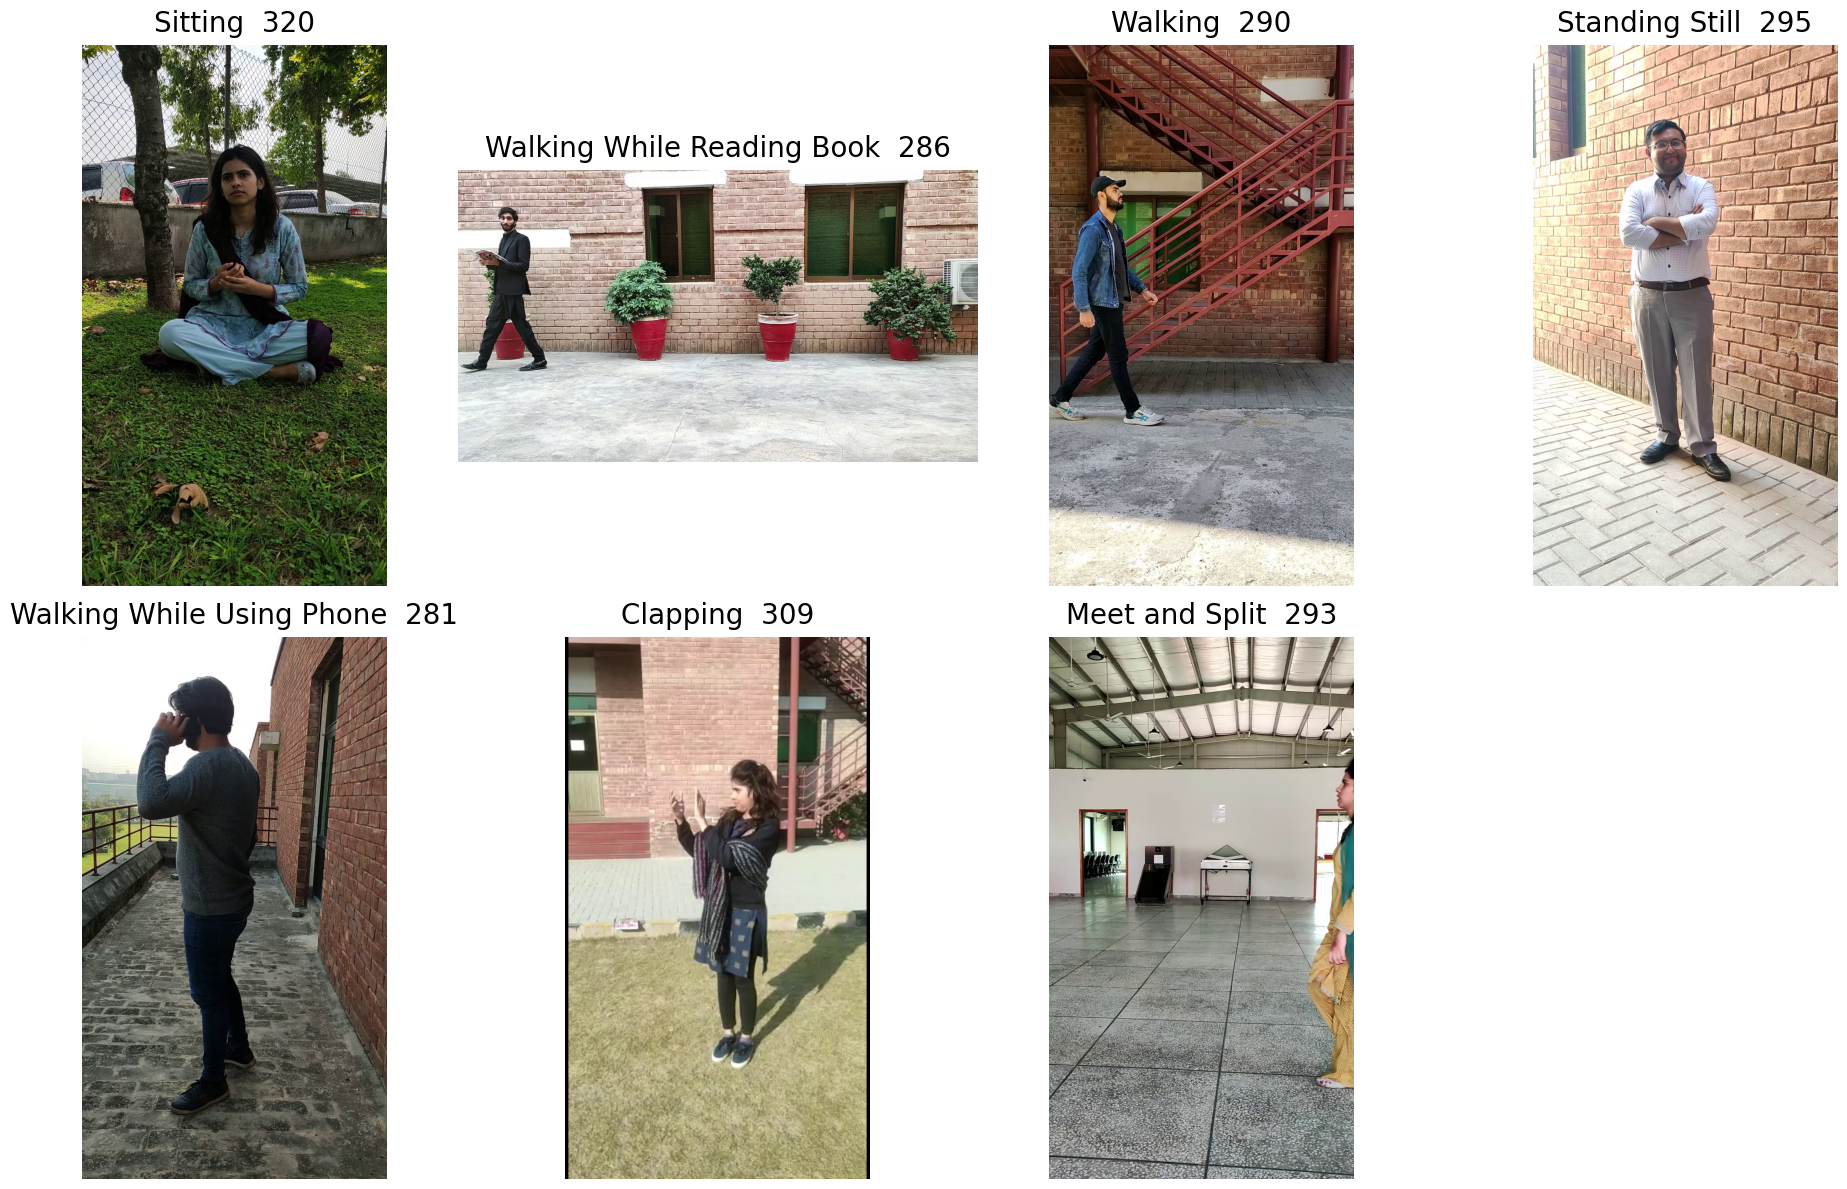

In [5]:


plt.figure(figsize=(20, 12))

n_samples = min(7, len(All_Classes))
random_sample = random.sample(range(len(All_Classes)), n_samples)

for counter, random_index in enumerate(random_sample, 1):
    sample = All_Classes[random_index]
    class_path = f'/kaggle/input/human-activities-dataset/Human Activity Recognition - Video Dataset/{sample}'
    video_files = os.listdir(class_path)
    if not video_files:
        print(f"Aucune vidéo trouvée pour la classe : {sample}")
        continue
    sample_video = random.choice(video_files)
    video_path = os.path.join(class_path, sample_video)
    video_reader = cv2.VideoCapture(video_path)
    num_frames = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    success, bgr_frame = video_reader.read()
    video_reader.release()
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)
    plt.subplot(2, 4, counter) 
    plt.imshow(rgb_frame)
    plt.axis('off')
    plt.title(f'{sample}  {num_frames}', fontsize=20, color='black', pad=10)

plt.tight_layout()
plt.show()


In [6]:

Height , Width = 128 , 128
FRAME = 10
DATA_PATH = '/kaggle/input/human-activities-dataset/Human Activity Recognition - Video Dataset'

In [7]:
def Frame_Extraction(video_path):
    frame_list = []
    video_reader = cv2.VideoCapture(video_path)
    num_frames = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    step = num_frames / FRAME
    success, bgr_frame = video_reader.read()
    if success:
        for frame_counter in range(FRAME):
            video_reader.set(cv2.CAP_PROP_POS_FRAMES, int(frame_counter * step))
            success, frame = video_reader.read() 
            if not success:
                break
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            resized_frame = cv2.resize(frame, (Height, Width))
            normalized_frame = resized_frame / 255
            frame_list.append(torch.tensor(normalized_frame).permute(2, 0, 1).float())
    video_reader.release()
    video_tensor = torch.stack(frame_list)
    return video_tensor
    

In [8]:
sample = Frame_Extraction('/kaggle/input/human-activities-dataset/Human Activity Recognition - Video Dataset/Clapping/Clapping (1).mp4')

In [9]:
print(type(sample))
print(sample.shape)

<class 'torch.Tensor'>
torch.Size([60, 3, 256, 256])


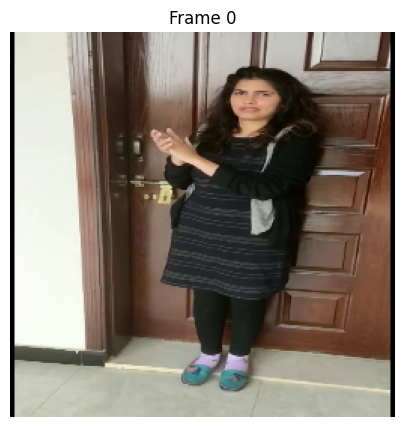

In [ ]:

frame0 = sample[0].permute(1, 2, 0).cpu().numpy() 
frame0 = frame0.clip(0, 1)
plt.figure(figsize=(5, 5))
plt.imshow(frame0)   
plt.axis('off')
plt.title("Frame 0")
plt.show()


In [11]:
!pip install moviepy --quiet


In [ ]:
from moviepy.editor import ImageSequenceClip
from IPython.display import display

print(f"Nombre de frames : {len(sample)}")
print(f"Dimension d'une frame : {sample[0].shape}")

frames_list = [frame.permute(1, 2, 0).cpu().numpy() for frame in sample]
frames_uint8 = [(frame * 255).astype(np.uint8) if frame.dtype != np.uint8 else frame for frame in frames_list]


fps = 10 
clip = ImageSequenceClip(frames_uint8, fps=fps)

clip.ipython_display(width=480)


error: XDG_RUNTIME_DIR not set in the environment.
ALSA lib confmisc.c:855:(parse_card) cannot find card '0'
ALSA lib conf.c:5178:(_snd_config_evaluate) function snd_func_card_inum returned error: No such file or directory
ALSA lib confmisc.c:422:(snd_func_concat) error evaluating strings
ALSA lib conf.c:5178:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1334:(snd_func_refer) error evaluating name
ALSA lib conf.c:5178:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5701:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2664:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:855:(parse_card) cannot find card '0'
ALSA lib conf.c:5178:(_snd_config_evaluate) function snd_func_card_inum returned error: No such file or directory
ALSA lib confmisc.c:422:(snd_func_concat) error evaluating strings
ALSA lib conf.c:5178:(_snd_config_evalu

Nombre de frames : 60
Dimension d'une frame : torch.Size([3, 256, 256])
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


In [ ]:

os.makedirs("features", exist_ok=True)


In [ ]:


saved_paths = []
labels = []

Classes = os.listdir(DATA_PATH)

for i, classe in enumerate(Classes):
    ALL_video = os.path.join(DATA_PATH, classe)
    files = os.listdir(ALL_video)
    for file in files:
        name = os.path.join(ALL_video, file)
        frame = Frame_Extraction(name)
        if len(frame) == FRAME:
            print(f'{name} was extracted successfully')
            save_path = f"/kaggle/working/features/video_{classe}_{len(saved_paths)}.pt"
            torch.save(frame, save_path)  
            saved_paths.append(save_path)
            labels.append(i)
    break


data = pd.DataFrame({
    "Path": saved_paths,
    "Label": labels
})
data.to_csv("Data_Clean.csv", index=False)


/kaggle/input/human-activities-dataset/Human Activity Recognition - Video Dataset/Sitting/Sitting (31).mp4 was extracted successfully
/kaggle/input/human-activities-dataset/Human Activity Recognition - Video Dataset/Sitting/Sitting (131).mp4 was extracted successfully
/kaggle/input/human-activities-dataset/Human Activity Recognition - Video Dataset/Sitting/Sitting (101).mp4 was extracted successfully
/kaggle/input/human-activities-dataset/Human Activity Recognition - Video Dataset/Sitting/Sitting (90).mp4 was extracted successfully
/kaggle/input/human-activities-dataset/Human Activity Recognition - Video Dataset/Sitting/Sitting (97).mp4 was extracted successfully
/kaggle/input/human-activities-dataset/Human Activity Recognition - Video Dataset/Sitting/Sitting (130).mp4 was extracted successfully
/kaggle/input/human-activities-dataset/Human Activity Recognition - Video Dataset/Sitting/Sitting (53).mp4 was extracted successfully
/kaggle/input/human-activities-dataset/Human Activity Recog

In [ ]:

shutil.make_archive('result', 'zip', '/kaggle/working/features')


'/kaggle/working/result.zip'